<a href="https://colab.research.google.com/github/Ilia-Gershen/TYP-project/blob/main/DeepLearningModelLSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Model:




In [ ]:
#Importing libraries and data from google drive
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

#for Normalization
from sklearn import preprocessing

from google.colab import drive #connecting google drive with Database of the project
drive.mount('/content/drive')

# Importing the csv made in data preprocessing stage
ETH = pd.read_csv("/content/drive/MyDrive/Database/ETH-preprocessed.csv")
ETH.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2017-11-19,347.401001,371.290985,344.739990,354.385986,354.385986,1.181530e+09
1,1,2017-11-20,354.093994,372.136993,353.289001,366.730011,366.730011,8.070270e+08
2,2,2017-11-21,367.442993,372.470001,350.692993,360.401001,360.401001,9.499120e+08
3,3,2017-11-22,360.312012,381.420013,360.147003,380.652008,380.652008,8.008190e+08
4,4,2017-11-23,381.438995,425.548004,376.088013,410.165985,410.165985,1.845680e+09


## Functions used in all models

In [ ]:
def DrawingTrainAndValLoss(historyDict): #Function helps to draw the validation and training loss of models, as well as rmsr of training and validation

  loss = historyDict["loss"]
  root_mean_squared_error = historyDict["root_mean_squared_error"]
  valLoss = historyDict["val_loss"]
  val_root_mean_squared_error = historyDict["val_root_mean_squared_error"]

  epochs = range(1, len(loss) + 1)

  fig, (ax1, ax2) = plt.subplots(1, 2)

  fig.set_figheight(5)
  fig.set_figwidth(15)

  ax1.plot(epochs, loss, label = 'Training Loss')
  ax1.plot(epochs, valLoss, label = 'Validation Loss')
  ax1.set(xlabel = "Epochs", ylabel = "Loss")
  ax1.legend()

  ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
  ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
  ax2.set(xlabel = "Epochs", ylabel = "Loss")
  ax2.legend()

  plt.show()

In [ ]:
def CalculateErrors(ETH_Test_Y, ETH_prediction): #Function calculates the evaluation metrics for the models and prints them

  mse = mean_squared_error(ETH_Test_Y.reshape(-1,7), ETH_prediction)
  print(f'MSE: {mse}')

  mae = mean_absolute_error(ETH_Test_Y.reshape(-1,7), ETH_prediction)
  print(f'MAE: {mae}')

  rmse = math.sqrt(mean_squared_error(ETH_Test_Y.reshape(-1,7), ETH_prediction))
  print(f'RMSE: {rmse}')

  mape = np.mean(np.abs(ETH_Test_Y.reshape(-1,7) - ETH_prediction )/np.abs(ETH_Test_Y.reshape(-1,7))) * 100
  print(f'MAPE: {mape}')

## LSTM-GRU 1
With closing price, one week prediciton window


### Data Processing

#### Split Data into Training and Testing sets


*   Training Period: 2017-11-19 to 2022-01-01
* Validation Period: 2022-01-01 to 2022-06-01
*   Testing Period: 2022-06-02 to 2022-11-19

Stage 1:
[]
<class 'list'>
Stage 2:
[array([1834.150513, 1775.078613, 1801.609497, 1805.204956, 1859.289673,
       1814.04834 , 1793.572266]), array([1789.82605 , 1665.042236, 1529.663452, 1445.216553, 1204.582764,
       1211.662842, 1233.206421]), array([1067.730713, 1086.519287,  993.63678 , 1127.656494, 1127.642456,
       1124.824585, 1051.421875]), array([1143.386719, 1226.844727, 1243.446899, 1199.831665, 1193.680664,
       1144.579224, 1098.943848]), array([1067.298828, 1059.767334, 1066.512817, 1073.766968, 1151.059082,
       1134.541016, 1186.973999]), array([1237.593384, 1222.506226, 1216.978271, 1168.401611, 1097.236572,
       1038.19165 , 1113.587158]), array([1191.526245, 1233.12915 , 1352.626465, 1338.635742, 1578.717896,
       1542.97522 , 1520.200684]), array([1576.749512, 1537.405151, 1549.297485, 1599.476685, 1445.383423,
       1441.806763, 1636.232666]), array([1725.46814 , 1727.406982, 1695.969482, 1681.517334, 1635.195801,
       1632.945435, 1618.874512]), 

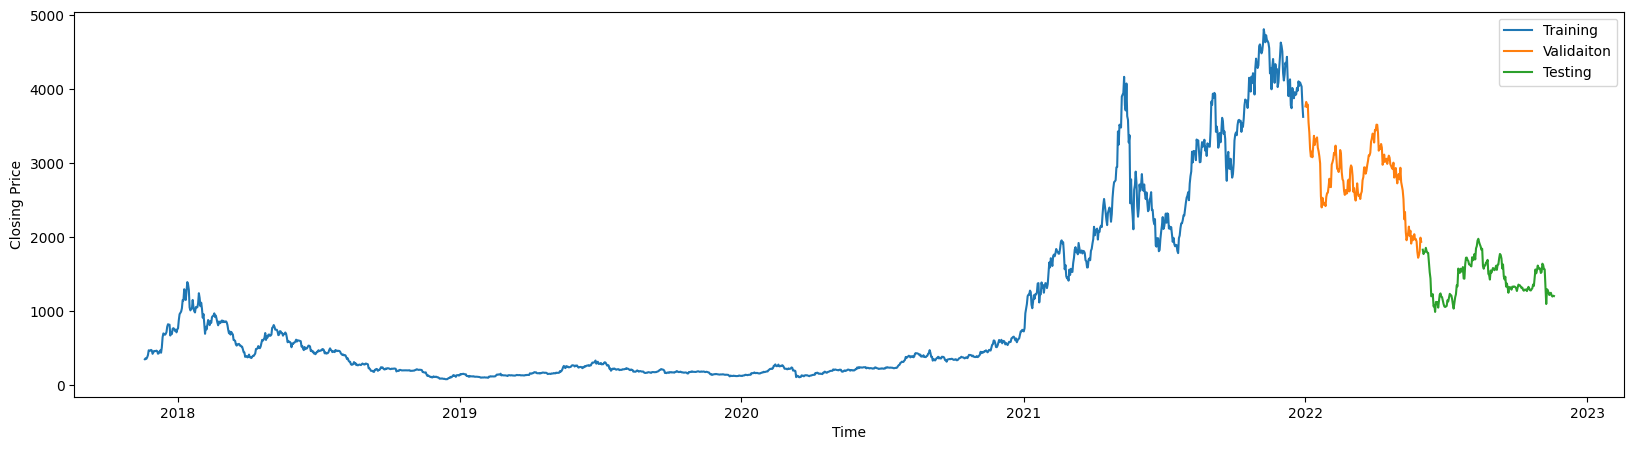

In [ ]:
def Dataset(Data): #function for creation of traning and testing datasets for the models

  #Swap date into right format
  Data["Date"] = pd.to_datetime(Data["Date"])

  #Data for Training
  #From 2018 to 2022
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  for i in range(0, len(Train_Data), 7): #putting in close values data in form of weeks aka 7 days
    try:
      TrainingData.append(Train_Data[i : i+7]) #array of arrays of 7 close prices
    except:
      pass

  if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
    TrainingData.pop(-1)

  TrainingDataX = TrainingData[0 : -1] # taking all but last element
  TrainingDataX = np.array(TrainingDataX)
  TrainingDataX = TrainingDataX.reshape((-1, 7, 1)) #split into groups of 7

  TrainingDataY = TrainingData[1:len(TrainingData)] # Taking all but first element
  TrainingDataY = np.array(TrainingDataY)
  TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) # split into groups of 7 and keep the order

  #Data for Validation
  #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  for i in range(0, len(Val_Data), 7):
    try:
      ValData.append(Val_Data[i : i + 7])
    except:
      pass

  if len(ValData[-1]) < 7:
    ValData.pop(-1)

  ValDataX = ValData[0 : -1]
  ValDataX = np.array(ValDataX)
  ValDataX = ValDataX.reshape((-1, 7, 1))

  ValDataY = ValData[1 : len(ValData)]
  ValDataY = np.array(ValDataY)
  ValDataY = ValDataY.reshape((-1, 7, 1))

  #Data for Testing
  #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  for i in range(0, len(Test_Data), 7):
    try:
      TestData.append(Test_Data[i : i+7])
    except:
      pass

  if len(TestData[-1]) < 7:
    TestData.pop(-1)

  print("Stage 1:")
  print(TestDataX)
  print(type(TestDataX))

  TestDataX = TestData[0 : -1]
  print("Stage 2:")
  print(TestDataX)
  print(type(TestDataX))
  TestDataX = np.array(TestDataX)
  print("Stage 3:")
  print(TestDataX)
  print(type(TestDataX))
  TestDataX = TestDataX.reshape((-1, 7, 1))
  print("Stage 4:")
  print(TestDataX)
  print(type(TestDataX))

  TestDataY = TestData[1 : len(TestData)]
  TestDataY = np.array(TestDataY)
  TestDataY = TestDataY.reshape((-1, 7, 1))

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH)

#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

print(type(ETH_Test_X))

### Model creation and testing

In [ ]:
def Model():

  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.LSTM(200, input_shape = (7,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

model = Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 200)            161600    
                                                                 
 gru (GRU)                   (None, 200)               241200    
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 428,307
Trainable params: 428,307
Non-trainable params: 0
_________________________________________________________________


### Learning Rate

In [ ]:
def scheduler(epoch):
  if epoch <= 100:
    lrate = epoch * (10 ** -6)
  else:
    lrate = 0.00001

  return lrate

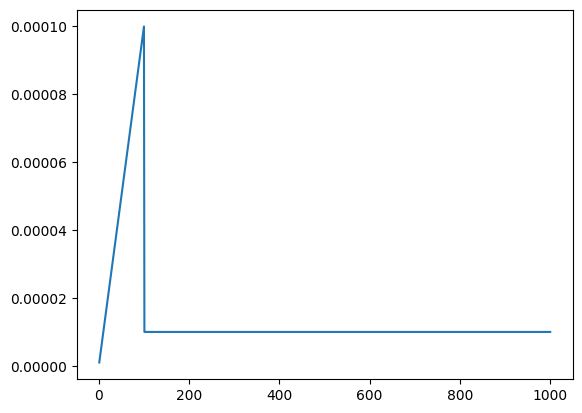

In [ ]:
epoch = [i for i in range(1, 1001)]
lrate = [scheduler(i) for i in range(1, 1001)]
plt.plot(epoch, lrate)

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Model Fitting

In [ ]:
ETH_Model = Model()

In [ ]:
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

Epoch 1/200
7/7 [==============================] - 5s 126ms/step - loss: 2147707.0000 - root_mean_squared_error: 1465.5057 - val_loss: 7770185.5000 - val_root_mean_squared_error: 2787.5054 - lr: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 47ms/step - loss: 2147360.2500 - root_mean_squared_error: 1465.3875 - val_loss: 7767925.0000 - val_root_mean_squared_error: 2787.0999 - lr: 1.0000e-06
Epoch 3/200
7/7 [==============================] - 0s 52ms/step - loss: 2145792.0000 - root_mean_squared_error: 1464.8522 - val_loss: 7762861.0000 - val_root_mean_squared_error: 2786.1912 - lr: 2.0000e-06
Epoch 4/200
7/7 [==============================] - 0s 48ms/step - loss: 2144222.7500 - root_mean_squared_error: 1464.3165 - val_loss: 7757857.5000 - val_root_mean_squared_error: 2785.2932 - lr: 3.0000e-06
Epoch 5/200
7/7 [==============================] - 0s 50ms/step - loss: 2141011.0000 - root_mean_squared_error: 1463.2194 - val_loss: 7748292.0000 - val_root_mean_squared_error: 2

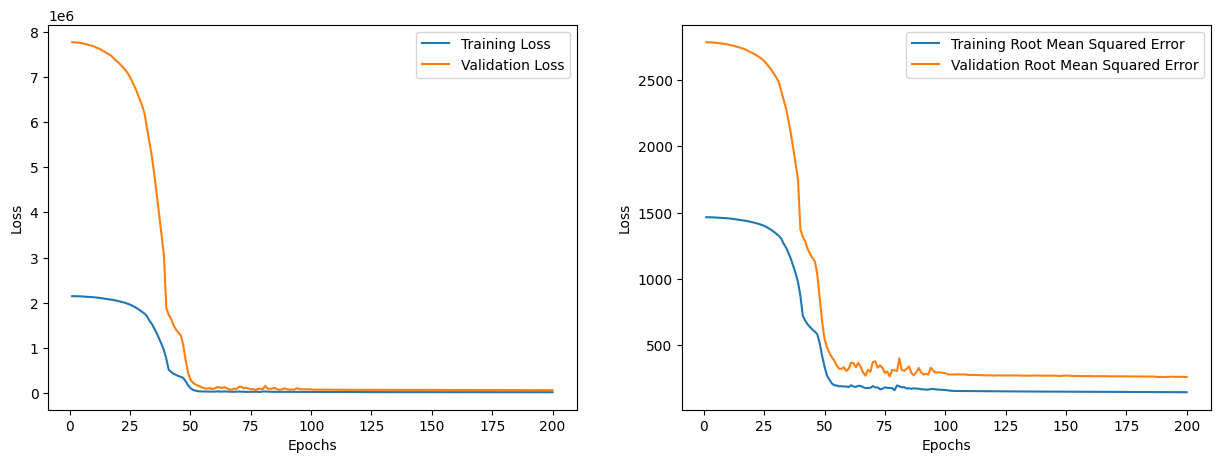

In [ ]:
DrawingTrainAndValLoss(ETH_hist.history)

### Predicting the closing price for ETH for a week

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

1/1 [==============================] - 0s 382ms/step


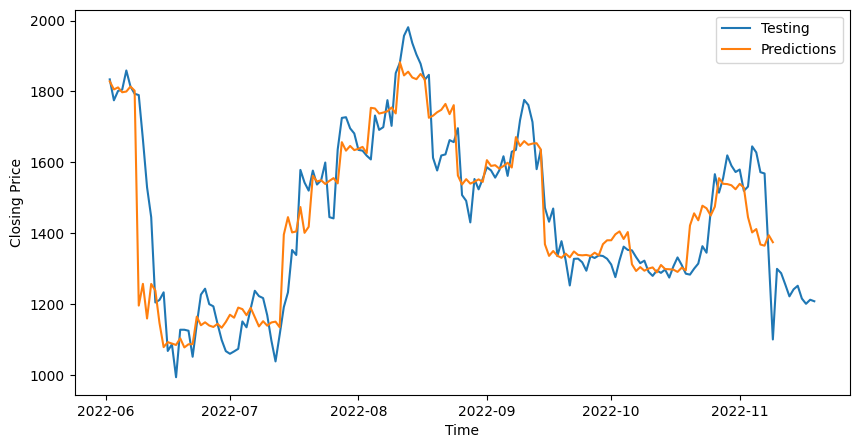

In [ ]:
plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
CalculateErrors(ETH_Test_Y, ETH_prediction)

MSE: 28746.35764209534
MAE: 125.09504613227871
RMSE: 169.54750851043298
MAPE: 8.825065676285945


# LSTM-GRU 2
The same model as previous one but with normalized closing price input

In [ ]:
def Model():
#The input shape is going to be 14 total 7 close and 7 volume
  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.LSTM(200, input_shape = (7,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

In [ ]:
def Dataset(Data, input): #function for creation of traning and testing datasets for the models
#input 1 for scaling to a range
#input 2 for Log scaling
#input 3 for z-score
  #Swap date into right format
  ETH["Date"] = pd.to_datetime(ETH["Date"])

  #Train_DataY = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy()
  #Data for Training
  #From 2018 to 2022
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  #0+
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy()

  #1502+
  Train_Data_Val = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy()

  #1652+
  Train_Data_Test = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()


  Train_Data = np.append(Train_Data,  Train_Data_Val)

  Train_Data = np.append(Train_Data,  Train_Data_Test)

  if input == 1:
    #Normalize by scaling to a range
    minn = min(Train_Data)
    maxx = max(Train_Data)
    for i in range(len(Train_Data)):
      new = (Train_Data[i]-minn)/(maxx-minn)
      Train_Data[i] = new


  elif input == 2:
    #Normalize by log scaling
    for i in range(len(Train_Data)):
      Train_Data[i] = math.log(Train_Data[i])

  else:
    #Normalize by Z-score
    sum = 0
    for i in Train_Data:
      sum += i
    mean = sum/len(Train_Data)
    standardDev = np.std(Train_Data)
    for i in range(len(Train_Data)):
      Train_Data[i] = (Train_Data[i] - mean)/standardDev


  Train_DataY = Train_Data[7:]

  Train_DataY = Train_DataY.reshape(1, -1)

  Train_Data = Train_Data.reshape(1, -1) #normalized data holding all the values for train and test


  #The training output of the model in TrainingDataY
  #for i in range(0, len(Train_DataY), 7): #putting in close values data in form of weeks aka 7 days
   # try:
   #   TrainingData.append(Train_DataY[i : i+7]) #array of arrays of 7 close prices
   # except:
   #   pass

 # if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  TrainingData.pop(-1)

  #TrainingDataY = TrainingData[1:len(TrainingData)] # Taking all but first element
  #TrainingDataY = np.array(TrainingDataY)
  #TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) #split into groups of 7

  #The training input for the model in TrainingDataX
  TrainingDataXWV = np.zeros((213, 7, 1))

  counter = 0
  for i in range(213):
    for l in range(7):
      TrainingDataXWV[i,l,0] = Train_Data[0,counter]
      counter += 1

  TrainingDataYWV = np.zeros((213, 7, 1))

  counter = 0
  for i in range(213):
    for l in range(7):
      TrainingDataYWV[i,l,0] = Train_DataY[0,counter]
      counter += 1

  TrainingDataX = TrainingDataXWV
  TrainingDataY = TrainingDataYWV


  #Data for Validation
  #From 2022 to 2022-06
  #Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  #Volume_Data = Data['Volume'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date

  #for i in range(0, len(Val_Data), 7): #putting in close values data in form of weeks aka 7 days
  #  try:
  #    ValData.append(Val_Data[i : i+7]) #array of arrays of 7 close prices
  #  except:
  #    pass

  #if len(ValData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  ValData.pop(-1)

  #ValDataY = ValData[1 : len(ValData)]
  #ValDataY = np.array(ValDataY)
 # ValDataY = ValDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  ValDataXWV = np.zeros((20, 7, 1))

  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataXWV[i,l,0] = Train_Data[0,1502+counter]
      counter += 1

  ValDataX = ValDataXWV

  ValDataYWV = np.zeros((20, 7, 1))
  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataYWV[i,l,0] = Train_DataY[0,1502+counter]
      counter += 1
  ValDataY = ValDataYWV
  #Data for Testing
  #From 2022-06 to the end
  #Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  #Volume_Data = Data['Volume'][Data['Date'] >= '2022-06-02'].to_numpy()

  #for i in range(0, len(Test_Data), 7): #putting in close values data in form of weeks aka 7 days
   # try:
   #   TestData.append(Test_Data[i : i+7]) #array of arrays of 7 close prices
   # except:
   #   pass

  #if len(TestData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  TestData.pop(-1)

  #TestDataY = TestData[1 : len(TestData)]
  #TestDataY = np.array(TestDataY)
 # TestDataY = TestDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  TestDataXWV = np.zeros((23, 7, 1))

  counter = 0
  for i in range(23):
    for l in range(7):
      #TrainingDataX[i, l].append(Volume_Data[counter])
      TestDataXWV[i,l,0] = Train_Data[0,1653+counter]
      counter += 1

  TestDataX = TestDataXWV

  TestDataYWV = np.zeros((23, 7, 1))
  counter = 0
  for i in range(23):
    for l in range(7):
      TestDataYWV[i,l,0] = Train_DataY[0,1653+counter]
      counter += 1
  TestDataY = TestDataYWV

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY


## Normalization: Scaling to a range

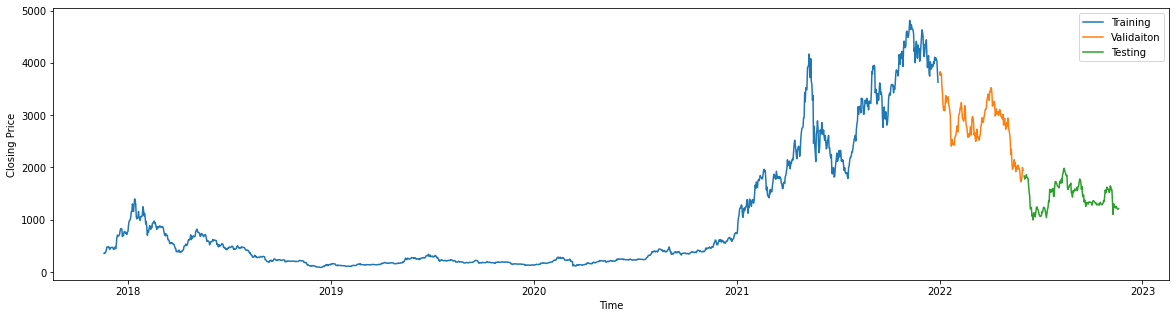

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 1)

#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

Epoch 1/200
7/7 [==============================] - 4s 122ms/step - loss: 0.0890 - root_mean_squared_error: 0.2983 - val_loss: 0.3118 - val_root_mean_squared_error: 0.5584 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 0s 55ms/step - loss: 0.0829 - root_mean_squared_error: 0.2879 - val_loss: 0.2896 - val_root_mean_squared_error: 0.5382 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 0s 56ms/step - loss: 0.0763 - root_mean_squared_error: 0.2763 - val_loss: 0.2601 - val_root_mean_squared_error: 0.5100 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 0s 54ms/step - loss: 0.0689 - root_mean_squared_error: 0.2625 - val_loss: 0.2227 - val_root_mean_squared_error: 0.4719 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 0s 50ms/step - loss: 0.0597 - root_mean_squared_error: 0.2443 - val_loss: 0.1817 - val_root_mean_squared_error: 0.4263 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 0s 55ms/step 

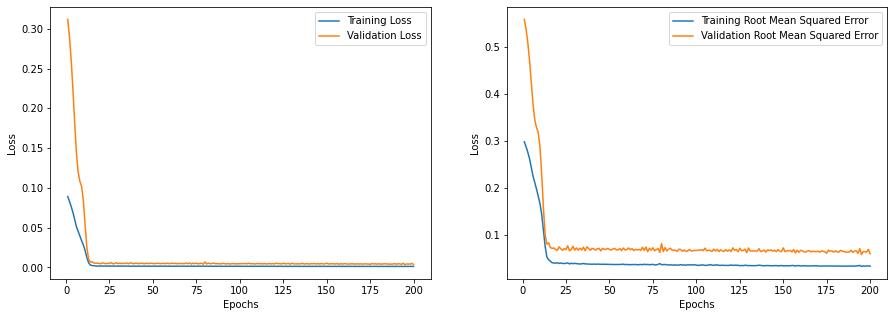

In [ ]:
def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()

ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 361ms/step
MSE: 0.0017945063544666693
MAE: 0.030524383359484857
RMSE: 0.042361614162667
MAPE: 11.277957522851874


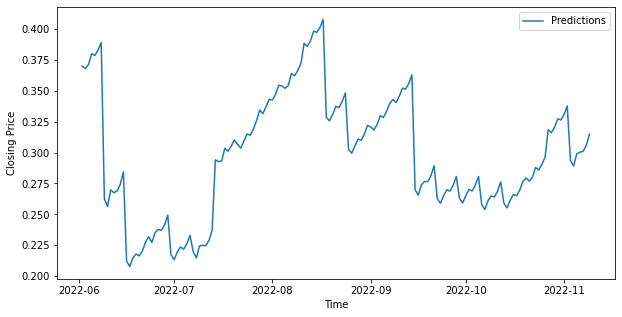

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

#plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

CalculateErrors(ETH_Test_Y, ETH_prediction)

## Normalization: Log Scaling

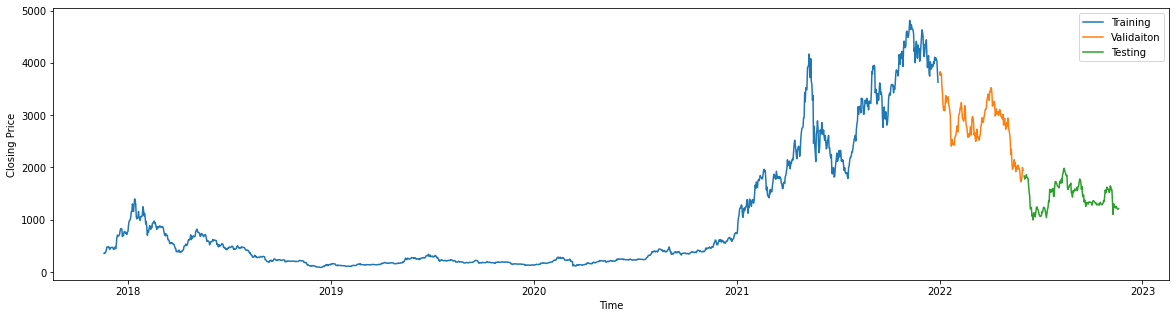

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 2)

#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

Epoch 1/200
7/7 [==============================] - 6s 132ms/step - loss: 38.3124 - root_mean_squared_error: 6.1897 - val_loss: 59.0553 - val_root_mean_squared_error: 7.6847 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 1s 99ms/step - loss: 34.9133 - root_mean_squared_error: 5.9087 - val_loss: 54.6368 - val_root_mean_squared_error: 7.3917 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 1s 103ms/step - loss: 31.2689 - root_mean_squared_error: 5.5919 - val_loss: 47.6422 - val_root_mean_squared_error: 6.9023 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 1s 100ms/step - loss: 25.2453 - root_mean_squared_error: 5.0245 - val_loss: 36.1829 - val_root_mean_squared_error: 6.0152 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 1s 113ms/step - loss: 17.2046 - root_mean_squared_error: 4.1478 - val_loss: 21.9576 - val_root_mean_squared_error: 4.6859 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 

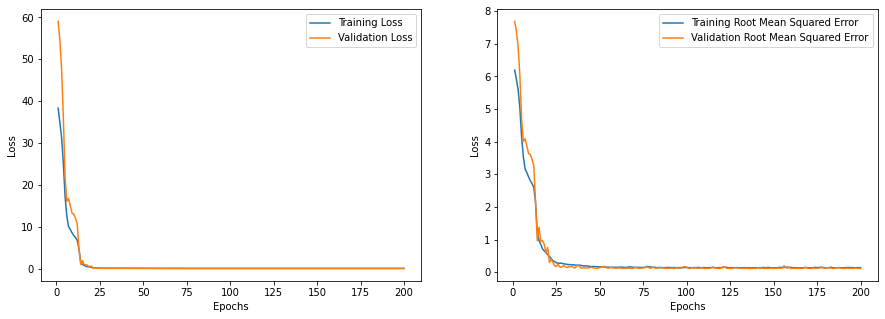

In [ ]:
def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()

ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 363ms/step
MSE: 0.021413340112348318
MAE: 0.10583936206121157
RMSE: 0.14633297684509913
MAPE: 1.468008691980708


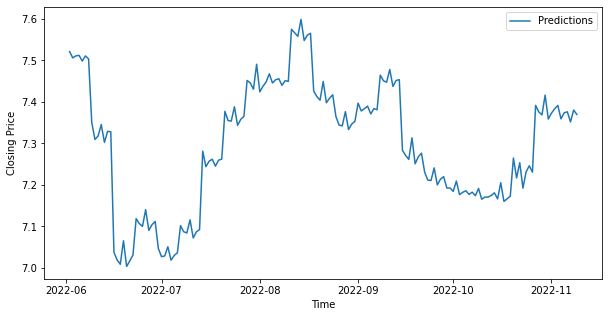

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

#plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

CalculateErrors(ETH_Test_Y, ETH_prediction)

## Normalization: Z-score

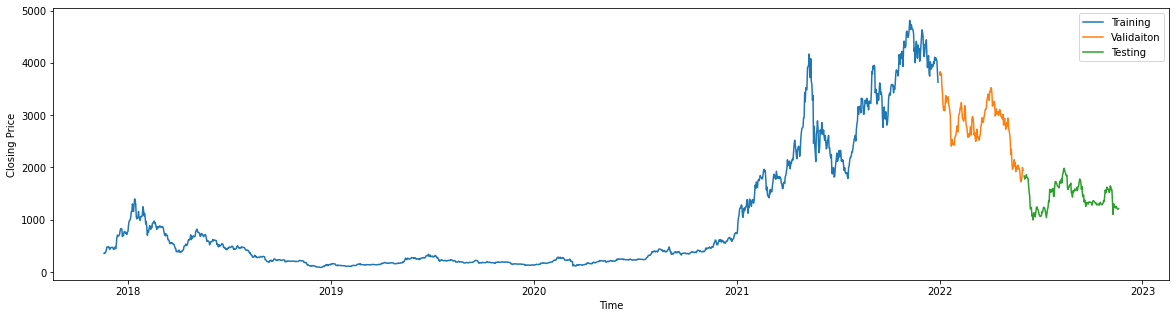

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 3)

#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

Epoch 1/100
7/7 [==============================] - 4s 120ms/step - loss: 0.9744 - root_mean_squared_error: 0.9871 - val_loss: 2.0140 - val_root_mean_squared_error: 1.4191 - lr: 1.5000e-04
Epoch 2/100
7/7 [==============================] - 0s 53ms/step - loss: 0.9588 - root_mean_squared_error: 0.9792 - val_loss: 1.9731 - val_root_mean_squared_error: 1.4047 - lr: 1.5000e-04
Epoch 3/100
7/7 [==============================] - 0s 63ms/step - loss: 0.9410 - root_mean_squared_error: 0.9700 - val_loss: 1.9201 - val_root_mean_squared_error: 1.3857 - lr: 1.5000e-04
Epoch 4/100
7/7 [==============================] - 0s 51ms/step - loss: 0.9156 - root_mean_squared_error: 0.9569 - val_loss: 1.8365 - val_root_mean_squared_error: 1.3552 - lr: 1.5000e-04
Epoch 5/100
7/7 [==============================] - 0s 53ms/step - loss: 0.8746 - root_mean_squared_error: 0.9352 - val_loss: 1.7072 - val_root_mean_squared_error: 1.3066 - lr: 1.5000e-04
Epoch 6/100
7/7 [==============================] - 0s 51ms/step 

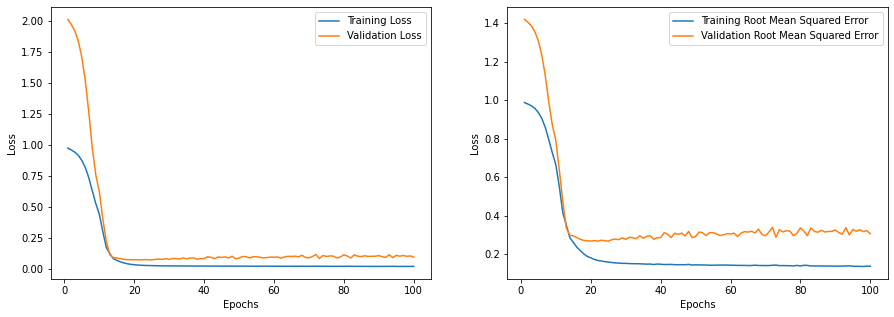

In [ ]:
def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()

ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 358ms/step
MSE: 0.09011381558102576
MAE: 0.24853176406334826
RMSE: 0.30018963270077426
MAPE: 884.2178234749834


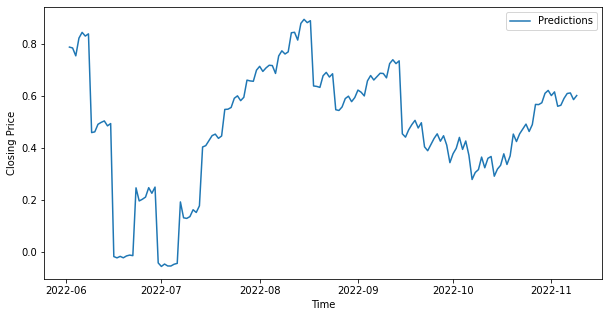

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

#plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

CalculateErrors(ETH_Test_Y, ETH_prediction)

# LSTM-GRU 3

With 1to1 format of input, but closing price and volume of trading are used as input

In [ ]:
def Model():
#The input shape is going to be 14 total 7 close and 7 volume
  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.LSTM(200, input_shape = (7,2), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

In [ ]:
def Dataset(Data, input): #function for creation of traning and testing datasets for the models

  #Swap date into right format
  Data["Date"] = pd.to_datetime(Data["Date"])

  #Data for Training
  #From 2018 to 2022
  #Train_DataY = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  #0+
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy()

  #1502+
  Train_Data_Val = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy()

  #1652+
  Train_Data_Test = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()

  Train_Data = np.append(Train_Data,  Train_Data_Val)

  Train_Data = np.append(Train_Data,  Train_Data_Test)

  if input == 1:
    #Normalize by scaling to a range
    minn = min(Train_Data)
    maxx = max(Train_Data)
    for i in range(len(Train_Data)):
      new = (Train_Data[i]-minn)/(maxx-minn)
      Train_Data[i] = new

  elif input == 2:
    #Normalize by log scaling
    for i in range(len(Train_Data)):
      Train_Data[i] = math.log(Train_Data[i])

  else:
    #Normalize by Z-score
    sum = 0
    for i in Train_Data:
      sum += i
    mean = sum/len(Train_Data)
    standardDev = np.std(Train_Data)
    for i in range(len(Train_Data)):
      Train_Data[i] = (Train_Data[i] - mean)/standardDev

  Train_DataY = Train_Data[7:]
  Train_DataY = Train_DataY.reshape(1, -1)

  Train_Data = Train_Data.reshape(1, -1)

  #0+
  Volume_Data = Data['Volume'][Data['Date'] < '2021-12-30'].to_numpy()

  #1502+
  Volume_Data_Val = Data['Volume'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy()

  #1652+
  Volume_Data_Test = Data['Volume'][Data['Date'] >= '2022-06-02'].to_numpy()

  Volume_Data = np.append(Volume_Data,  Volume_Data_Val)

  Volume_Data = np.append(Volume_Data,  Volume_Data_Test)

  if input == 1:
    #Normalize by scaling to a range
    minn = min(Volume_Data)
    maxx = max(Volume_Data)
    for i in range(len(Volume_Data)):
      new = (Volume_Data[i]-minn)/(maxx-minn)
      Volume_Data[i] = new

  elif input == 2:
    #Normalize by log scaling
    for i in range(len(Volume_Data)):
      Volume_Data[i] = math.log(Volume_Data[i])

  else:
    #Normalize by Z-score
    sum = 0
    for i in Volume_Data:
      sum += i
    mean = sum/len(Volume_Data)
    standardDev = np.std(Volume_Data)
    for i in range(len(Volume_Data)):
      Volume_Data[i] = (Volume_Data[i] - mean)/standardDev

  Volume_Data = Volume_Data.reshape(1, -1)

  #The training output of the model in TrainingDataY
  #for i in range(0, len(Train_DataY), 7): #putting in close values data in form of weeks aka 7 days
  #  try:
   #   TrainingData.append(Train_DataY[i : i+7]) #array of arrays of 7 close prices
   # except:
   #   pass

  #if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  TrainingData.pop(-1)

  #TrainingDataY = TrainingData[1:len(TrainingData)] # Taking all but first element
 # TrainingDataY = np.array(TrainingDataY)
  #TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) #split into groups of 7

  #The training input for the model in TrainingDataX
  TrainingDataXWV = np.zeros((213, 7, 2))

  counter = 0
  for i in range(213):
    for l in range(7):
      TrainingDataXWV[i,l,0] = Train_Data[0,counter]
      TrainingDataXWV[i,l,1] = Volume_Data[0,counter]
      counter += 1

  TrainingDataX = TrainingDataXWV

  TrainDataYWV = np.zeros((213, 7, 1))
  counter = 0
  for i in range(213):
    for l in range(7):
      TrainDataYWV[i,l,0] = Train_DataY[0,counter]
      counter += 1
  TrainingDataY = TrainDataYWV

  #Data for Validation
  #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  #Volume_Data = Data['Volume'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date

  #for i in range(0, len(Val_Data), 7): #putting in close values data in form of weeks aka 7 days
   # try:
   #   ValData.append(Val_Data[i : i+7]) #array of arrays of 7 close prices
  #  except:
   #   pass

 # if len(ValData[-1]) < 7: #If last week is less then 7 days we remove last week
 #   ValData.pop(-1)

 # ValDataY = ValData[1 : len(ValData)]
 # ValDataY = np.array(ValDataY)
 # ValDataY = ValDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  ValDataXWV = np.zeros((20, 7, 2))

  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataXWV[i,l,0] = Train_Data[0,1502+counter]
      ValDataXWV[i,l,1] = Volume_Data[0,1502+counter]
      counter += 1

  ValDataX = ValDataXWV

  ValDataYWV = np.zeros((20, 7, 1))
  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataYWV[i,l,0] = Train_DataY[0,1502+counter]
      counter += 1
  ValDataY = ValDataYWV

  #Data for Testing
  #From 2022-06 to the end
  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  #Volume_Data = Data['Volume'][Data['Date'] >= '2022-06-02'].to_numpy()

  #for i in range(0, len(Test_Data), 7): #putting in close values data in form of weeks aka 7 days
  #  try:
   #   TestData.append(Test_Data[i : i+7]) #array of arrays of 7 close prices
   # except:
   #   pass

  #if len(TestData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  TestData.pop(-1)

 # TestDataY = TestData[1 : len(TestData)]
 # TestDataY = np.array(TestDataY)
  #TestDataY = TestDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  TestDataXWV = np.zeros((23, 7, 2))

  counter = 0
  for i in range(23):
    for l in range(7):
      #TrainingDataX[i, l].append(Volume_Data[counter])
      TestDataXWV[i,l,0] = Train_Data[0,1653+counter]
      TestDataXWV[i,l,1] = Volume_Data[0,1653+counter]
      counter += 1

  TestDataX = TestDataXWV

  TestDataYWV = np.zeros((23, 7, 1))
  counter = 0
  for i in range(23):
    for l in range(7):
      TestDataYWV[i,l,0] = Train_DataY[0,1653+counter]
      counter += 1
  TestDataY = TestDataYWV

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

## Normalized by scaling to a range

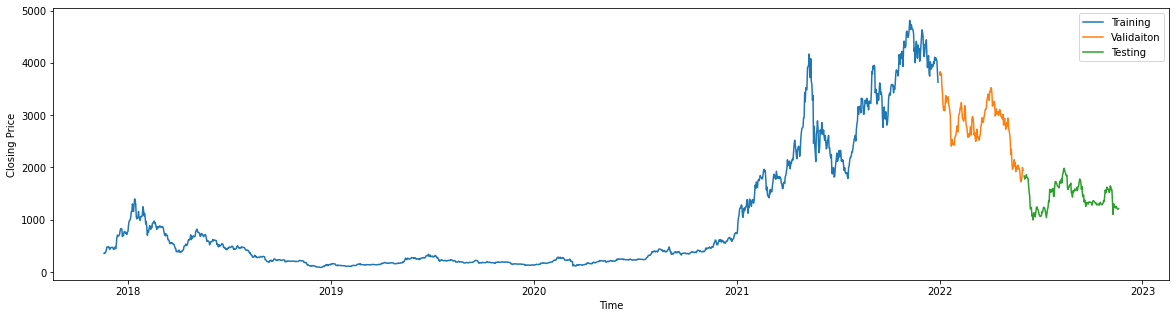

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 1)

#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

Epoch 1/200
7/7 [==============================] - 5s 133ms/step - loss: 0.0885 - root_mean_squared_error: 0.2974 - val_loss: 0.3125 - val_root_mean_squared_error: 0.5590 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 0s 49ms/step - loss: 0.0827 - root_mean_squared_error: 0.2877 - val_loss: 0.2886 - val_root_mean_squared_error: 0.5372 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 0s 56ms/step - loss: 0.0756 - root_mean_squared_error: 0.2749 - val_loss: 0.2582 - val_root_mean_squared_error: 0.5081 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 1s 83ms/step - loss: 0.0670 - root_mean_squared_error: 0.2589 - val_loss: 0.2195 - val_root_mean_squared_error: 0.4685 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 1s 84ms/step - loss: 0.0559 - root_mean_squared_error: 0.2365 - val_loss: 0.1737 - val_root_mean_squared_error: 0.4168 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 1s 82ms/step 

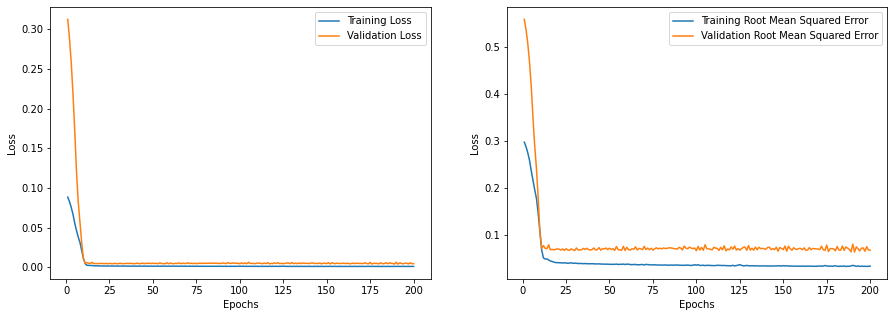

In [ ]:
def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()

ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 1s 653ms/step
MSE: 0.0025399764471631366
MAE: 0.03759912412200513
RMSE: 0.05039817900641983
MAPE: 14.193214314209257


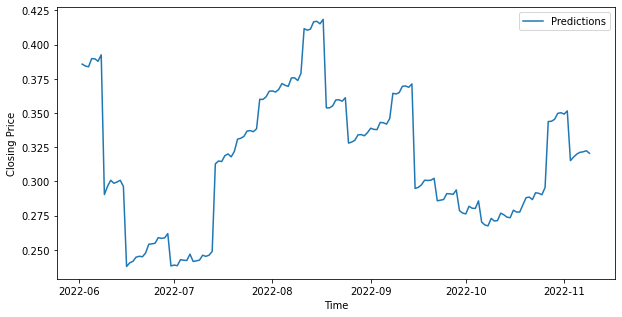

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

#plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

CalculateErrors(ETH_Test_Y, ETH_prediction)

## Normalize by log scaling

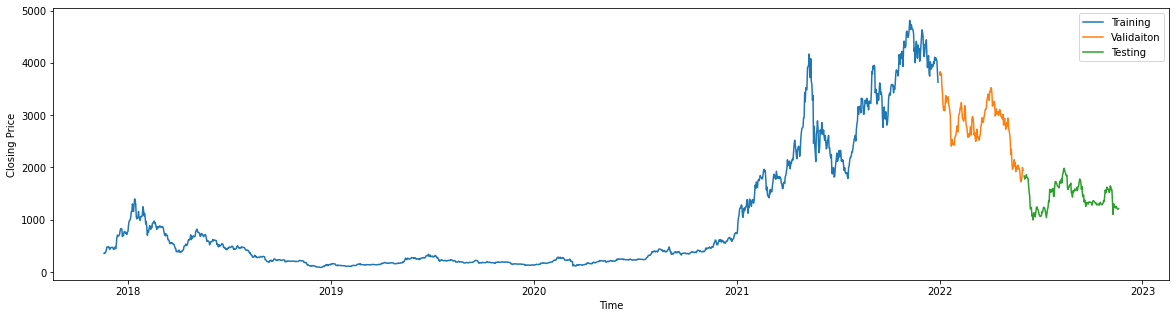

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 2)

#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

Epoch 1/200
7/7 [==============================] - 5s 126ms/step - loss: 36.6468 - root_mean_squared_error: 6.0537 - val_loss: 56.5536 - val_root_mean_squared_error: 7.5202 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 0s 48ms/step - loss: 32.8004 - root_mean_squared_error: 5.7272 - val_loss: 49.7850 - val_root_mean_squared_error: 7.0558 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 0s 51ms/step - loss: 27.6783 - root_mean_squared_error: 5.2610 - val_loss: 41.1247 - val_root_mean_squared_error: 6.4129 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 0s 48ms/step - loss: 22.3164 - root_mean_squared_error: 4.7240 - val_loss: 32.2927 - val_root_mean_squared_error: 5.6827 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 0s 57ms/step - loss: 18.3873 - root_mean_squared_error: 4.2880 - val_loss: 24.8433 - val_root_mean_squared_error: 4.9843 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 0s 

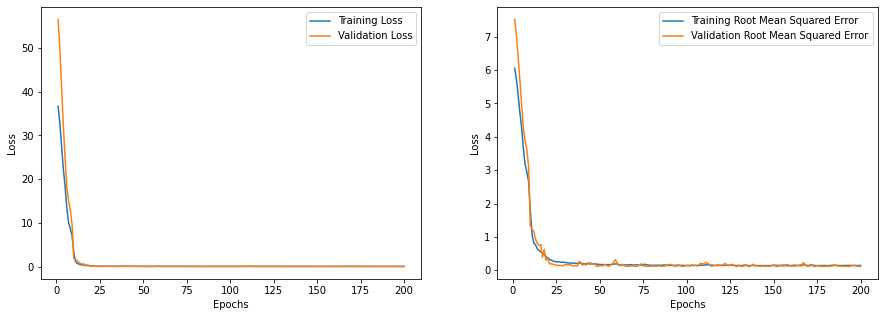

In [ ]:
def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()

ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 389ms/step
MSE: 0.019990496535838072
MAE: 0.10552713743662265
RMSE: 0.14138775242515905
MAPE: 1.461215461523486


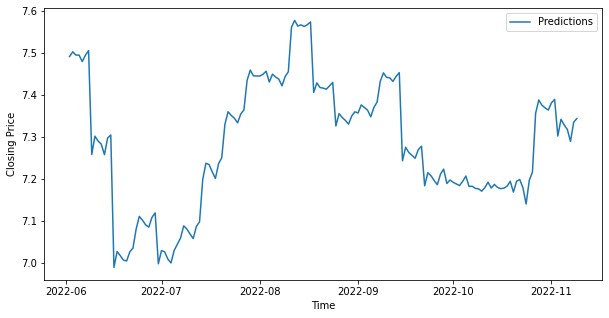

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

#plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

CalculateErrors(ETH_Test_Y, ETH_prediction)

## Normalize by Z-score

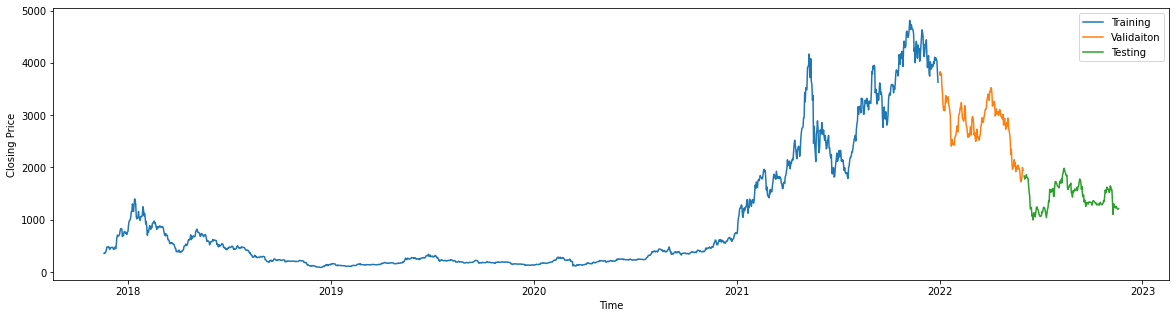

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 3)

#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

Epoch 1/200
7/7 [==============================] - 6s 210ms/step - loss: 0.9646 - root_mean_squared_error: 0.9821 - val_loss: 1.9817 - val_root_mean_squared_error: 1.4077 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 1s 89ms/step - loss: 0.9422 - root_mean_squared_error: 0.9707 - val_loss: 1.9163 - val_root_mean_squared_error: 1.3843 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 1s 88ms/step - loss: 0.9160 - root_mean_squared_error: 0.9571 - val_loss: 1.8203 - val_root_mean_squared_error: 1.3492 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 0s 67ms/step - loss: 0.8800 - root_mean_squared_error: 0.9381 - val_loss: 1.6841 - val_root_mean_squared_error: 1.2977 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 0s 50ms/step - loss: 0.8294 - root_mean_squared_error: 0.9107 - val_loss: 1.4983 - val_root_mean_squared_error: 1.2241 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 0s 53ms/step 

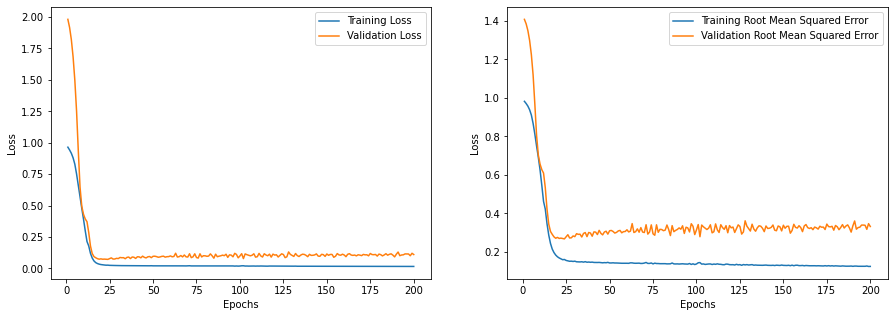

In [ ]:
def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()

ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 386ms/step
MSE: 0.06367125976786893
MAE: 0.18642992199097547
RMSE: 0.2523316463859992
MAPE: 776.3559856233317


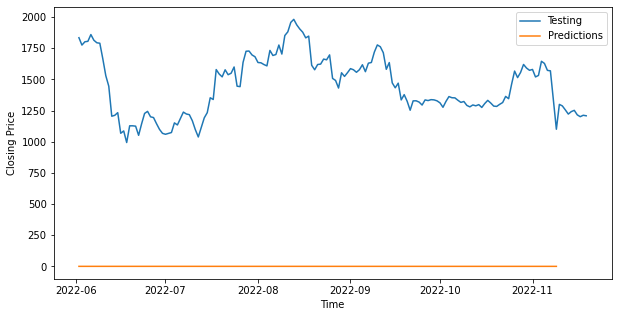

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

CalculateErrors(ETH_Test_Y, ETH_prediction)